In [28]:
from collections import defaultdict
import csv
import sys

import cv2
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
import numpy as np
import tifffile as tiff

csv.field_size_limit(sys.maxsize);
import operator
import numpy as np
from osgeo import gdal, gdal_array, osr, gdalnumeric
import shapefile
try:
    import Image
    import ImageDraw
except:
    from PIL import Image, ImageDraw
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import rasterio as rio
from rasterio.plot import show
from rasterio.plot import show_hist

In [29]:
shablon = '/home/dilara/project2/new_mt/'

In [30]:
train_mask = []
for i in range(512):
    train_mask.append(shablon+'masks/buildings/{}.tif'.format(i))
        # '/home/dilara/project2/sentinel/masks and tifs/mask_building_tif_105/mask_temp.{}.tif'.format(i))

val_mask = []
for i in range(512, 700):
    val_mask.append(shablon+'masks/buildings/{}.tif'.format(i))
        # '/home/dilara/project2/sentinel/masks and tifs/mask_building_tif_105/mask_temp.{}.tif'.format(i))

train_img = []
for i in range(512):
    train_img.append(shablon+'collection/{}.tif'.format(i))
        # '/home/dilara/project2/sentinel/masks and tifs/building_tif_105/temp.{}.tif'.format(i))

val_img = []
for i in range(512, 700):
    val_img.append(shablon+'collection/{}.tif'.format(i))
        # '/home/dilara/project2/sentinel/masks and tifs/building_tif_105/temp.{}.tif'.format(i))

In [31]:
def generator(flag, gen_mask, batch_size, gen_img, shape=(500, 500, 1)):
    '''
    train:    flag = 1
    validate: flag = 0
    + using augmentations
    '''
    
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):
            
            if flag == 1:
                ind = np.random.randint(0, 512);
            else:
                ind = np.random.randint(512, 700)
            img0 = gdal_array.LoadFile(gen_img[ind % 512])
            mask = gdal_array.LoadFile(gen_mask[ind % 512])
            while mask.shape[0] < shape[0] or mask.shape[1] < shape[1]:
                if flag == 1:
                    ind = np.random.randint(0, 512);
                else:
                    ind = np.random.randint(512, 700)
                img0 = gdal_array.LoadFile(gen_img[ind % 512])
                mask = gdal_array.LoadFile(gen_mask[ind % 512])

            mask.reshape(shape)
            img = img0
            img = img.T
            mask = mask.T
            
            img = cv2.resize(img, (256, 256))
            mask = cv2.resize(mask, (256, 256))
            
            # augmentations
            choose = np.random.uniform(0, 1)
            numb = np.random.randint(0, 4)
            if choose > 0.5:
                x_batch += [np.rot90(img[:,:,:3], k=numb)]
                y_batch += [np.rot90(mask, k=numb)]
            else:
                x_batch += [np.flip(np.rot90(img[:,:,:3], k=numb), 1)]
                y_batch += [np.flip(np.rot90(mask, k=numb), 1)]


        x_batch = np.array(x_batch) / 255.
        y_batch = np.array(y_batch)

        yield x_batch, np.expand_dims(y_batch, -1)

In [32]:
for x, y in generator(1, train_mask, 16, train_img, shape=(500, 500, 1)):
    break

In [33]:
x.shape

(16, 256, 256, 3)

In [34]:
y.shape

(16, 256, 256, 1)

ПРОВЕРКА 1

In [37]:
ind = 6
img = x[ind]

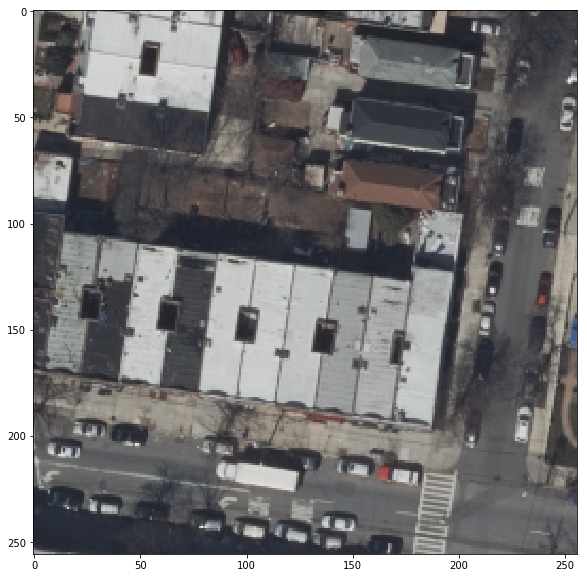

In [38]:
plt.figure(figsize=(10,10))
imshow(img)
plt.show()

In [39]:
img.shape

(256, 256, 3)

In [40]:
img2 = y[ind]
img2 = img2.squeeze()
img2.shape

(256, 256)

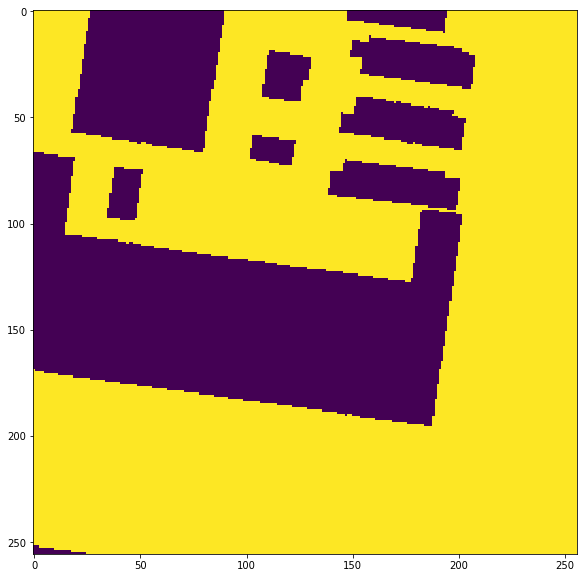

In [41]:
plt.figure(figsize=(10,10))
imshow(img2)
plt.show()

In [42]:
img2.shape

(256, 256)

ПРОВЕРКА 1 КОНЕЦ

# U-Net

In [43]:
import keras
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Input, Dense, Concatenate, GlobalAveragePooling2D
from keras.layers import Dropout, UpSampling2D, Conv2D, MaxPooling2D, Activation

In [44]:
#1-1#
input_im = Input(shape=(256, 256, 3))                                          # shape=(?, 256, 256, 3)
conv11 = Conv2D(32, (3, 3), padding='same', activation='relu')(input_im)       # shape=(?, 256, 256, 32)
conv12 = Conv2D(32, (3, 3), padding='same', activation='relu')(conv11) 

#1-2#
pool1 = MaxPooling2D(2)(conv12)                                                # shape=(?, 128, 128, 32)
conv21 = Conv2D(64, (3, 3), padding='same', activation='relu')(pool1)          # shape=(?, 128, 128, 64)
conv22 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv21)

#1-3#
pool2 = MaxPooling2D(2)(conv22)                                                # shape=(?, 64, 64, 64)
conv31 = Conv2D(128, (3, 3), padding='same', activation='relu')(pool2)         # shape=(?, 64, 64, 128)
conv32 = Conv2D(128, (3, 3), padding='same', activation='relu')(conv31)

#1-4#
pool3 = MaxPooling2D(2)(conv32)                                                # shape=(?, 32, 32, 128)
conv41 = Conv2D(256, (3, 3), padding='same', activation='relu')(pool3)         # shape=(?, 32, 32, 256)
conv42 = Conv2D(256, (3, 3), padding='same', activation='relu')(conv41)

#5#
pool4 = MaxPooling2D(2)(conv42)                                                # shape=(?, 16, 16, 256)
conv51 = Conv2D(512, (3, 3), padding='same', activation='relu')(pool4)         # shape=(?, 16, 16, 512)
conv52 = Conv2D(512, (3, 3), padding='same', activation='relu')(conv51) 

#2-4#
up1 = UpSampling2D(2, interpolation='bilinear')(conv52)                        # shape=(?, 32, 32, 512)
conc1 = Concatenate()([conv42, up1])
conv_up11 = Conv2D(256, (3, 3), padding='same', activation='relu')(conc1)      # shape=(?, 32, 32, 256)
conv_up12 = Conv2D(256, (3, 3), padding='same', activation='relu')(conv_up11)

#2-3#
up2 = UpSampling2D(2, interpolation='bilinear')(conv_up12)                     # shape=(?, 64, 64, 256)
conc2 = Concatenate()([conv32, up2])                                           # shape=(?, 64, 64, 384)
conv_up21 = Conv2D(128, (3, 3), padding='same', activation='relu')(conc2)      # shape=(?, 64, 64, 128)
conv_up22 = Conv2D(128, (3, 3), padding='same', activation='relu')(conv_up21)

#2-2#
up3 = UpSampling2D(2, interpolation='bilinear')(conv_up22)                     # shape=(?, 128, 128, 128)
conc3 = Concatenate()([conv22, up3])                                           # shape=(?, 128, 128, 192)
conv_up31 = Conv2D(64, (3, 3), padding='same', activation='relu')(conc3)       # shape=(?, 128, 128, 64)
conv_up32 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv_up31)

#2-1#
up4 = UpSampling2D(2, interpolation='bilinear')(conv_up32)                     # shape=(?, 256, 256, 64)
conc4 = Concatenate()([conv12, up4])                                           # shape=(?, 256, 256, 96)
conv_up41 = Conv2D(32, (3, 3), padding='same', activation='relu')(conc4)       # shape=(?, 256, 256, 32)
conv_up42 = Conv2D(1, (3, 3), padding='same', activation='sigmoid')(conv_up41) # shape=(?, 256, 256, 1)
result = conv_up42

model = Model(inputs=input_im, outputs=result)

In [45]:
best_w = keras.callbacks.ModelCheckpoint('unet_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('unet_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]



adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


model.compile(adam, 'binary_crossentropy')

In [49]:
batch_size = 8
model.fit_generator(generator(1, train_mask, batch_size, train_img),
              steps_per_epoch=64,
              epochs=15,
              verbose=1,
              callbacks=callbacks,
              validation_data=generator(0, val_mask, batch_size, val_img),
              validation_steps=24,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)

Epoch 1/15
64/64 [==============================] - 1115s 17s/step - loss: 0.6615 - val_loss: 0.5845
Epoch 2/15
64/64 [==============================] - 1176s 18s/step - loss: 0.6104 - val_loss: 0.4881
Epoch 3/15
64/64 [==============================] - 1102s 17s/step - loss: 0.5350 - val_loss: 0.5058
Epoch 4/15
64/64 [==============================] - 1193s 19s/step - loss: 0.4980 - val_loss: 0.5121
Epoch 5/15
64/64 [==============================] - 1095s 17s/step - loss: 0.4668 - val_loss: 0.5095
Epoch 6/15
64/64 [==============================] - 1053s 16s/step - loss: 0.4527 - val_loss: 0.4807
Epoch 7/15
64/64 [==============================] - 1094s 17s/step - loss: 0.4491 - val_loss: 0.4916
Epoch 8/15
64/64 [==============================] - 1087s 17s/step - loss: 0.4296 - val_loss: 0.5027
Epoch 9/15
64/64 [==============================] - 1192s 19s/step - loss: 0.3934 - val_loss: 0.4453
Epoch 10/15
64/64 [==============================] - 1149s 18s/step - loss: 0.4140 - val_lo

In [50]:
model.save('my_new.model')

In [36]:
# mo = keras.models.load_model('my_new.model')

In [72]:
'''for x, y in generator(0, val_mask, 16, val_img, shape=(500, 500, 1)):
    break'''

In [73]:
'''pred = model.predict(x)#.shape'''

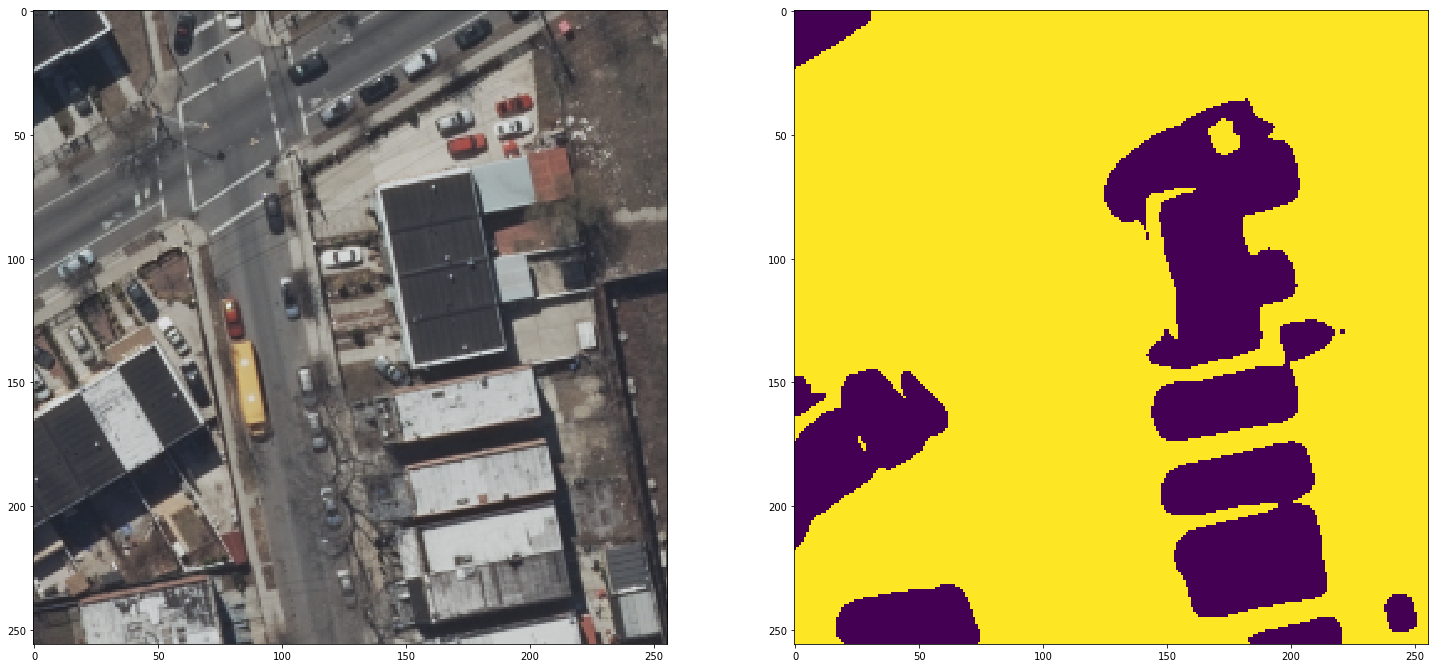

In [83]:
im_id = 13
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
axes[0].imshow(x[im_id])
axes[1].imshow(pred[im_id, ..., 0]>0.5)

plt.show()

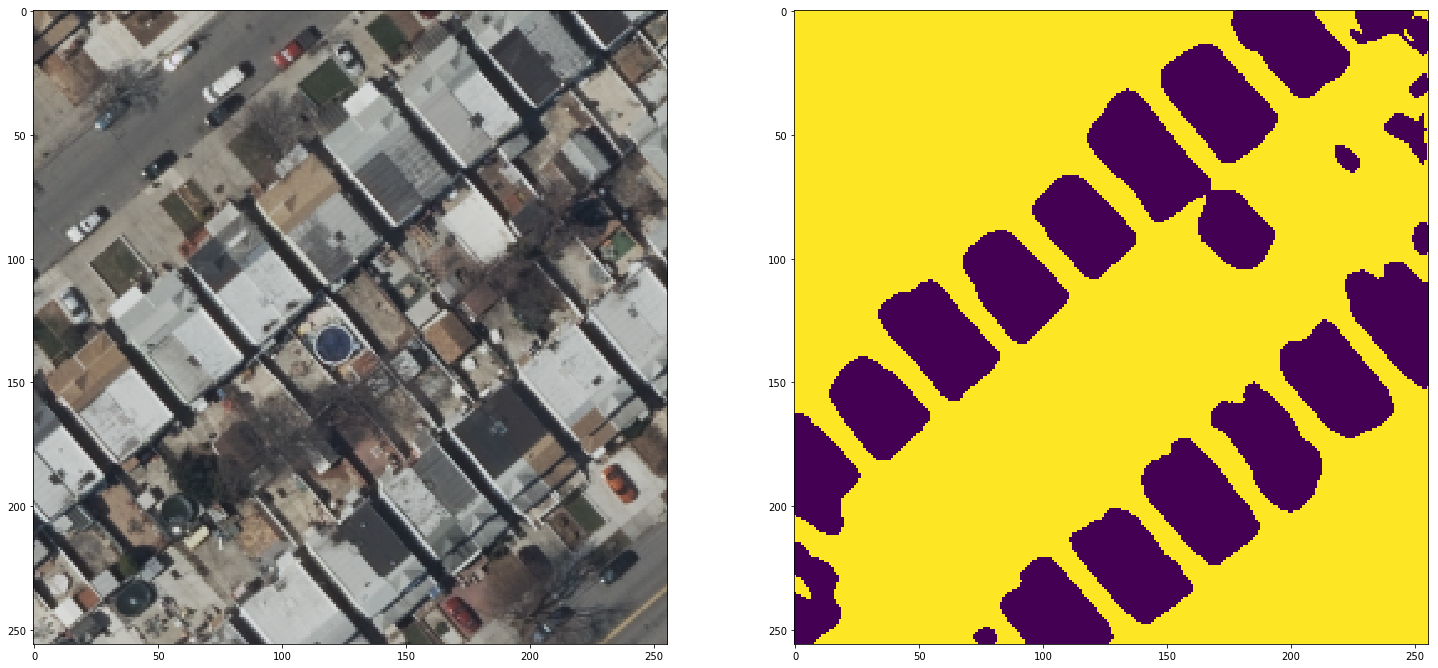

In [65]:
im_id = 11
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
axes[0].imshow(x[im_id])
axes[1].imshow(pred[im_id, ..., 0]>0.5)

plt.show()

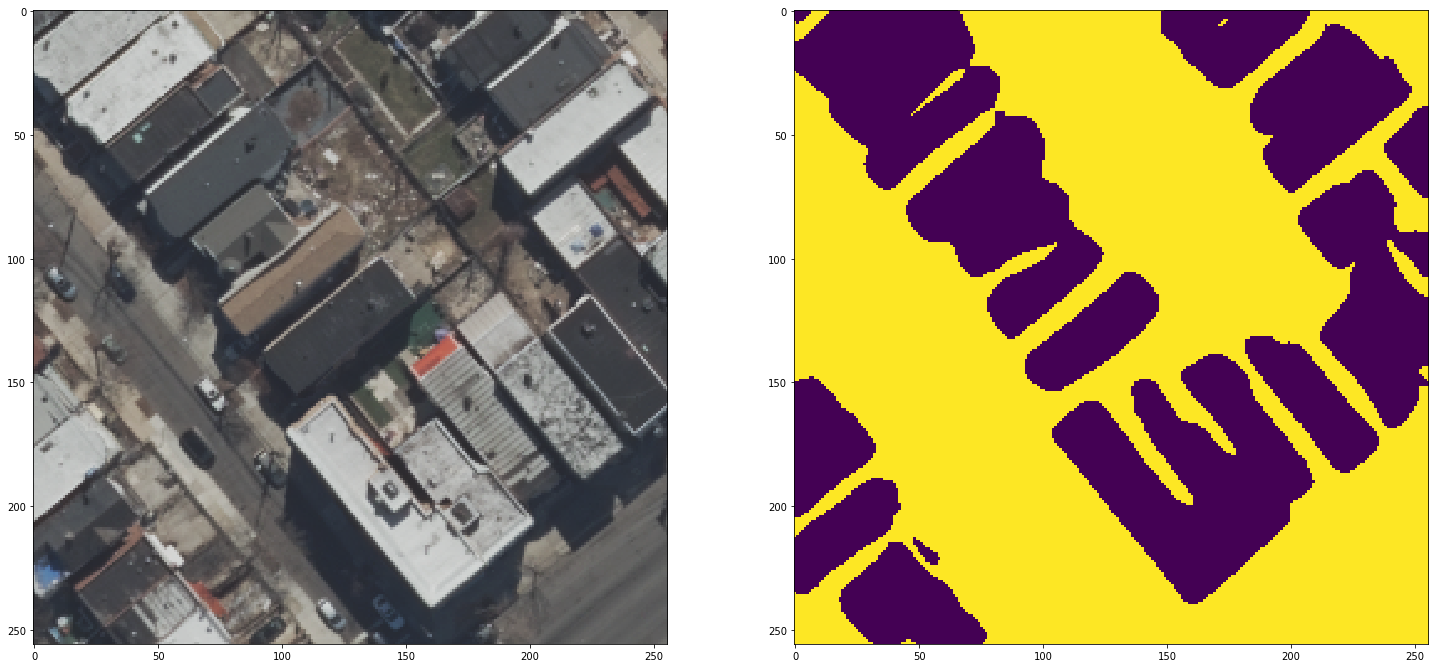

In [68]:
im_id = 13
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
axes[0].imshow(x[im_id])
axes[1].imshow(pred[im_id, ..., 0]>0.5)

plt.show()

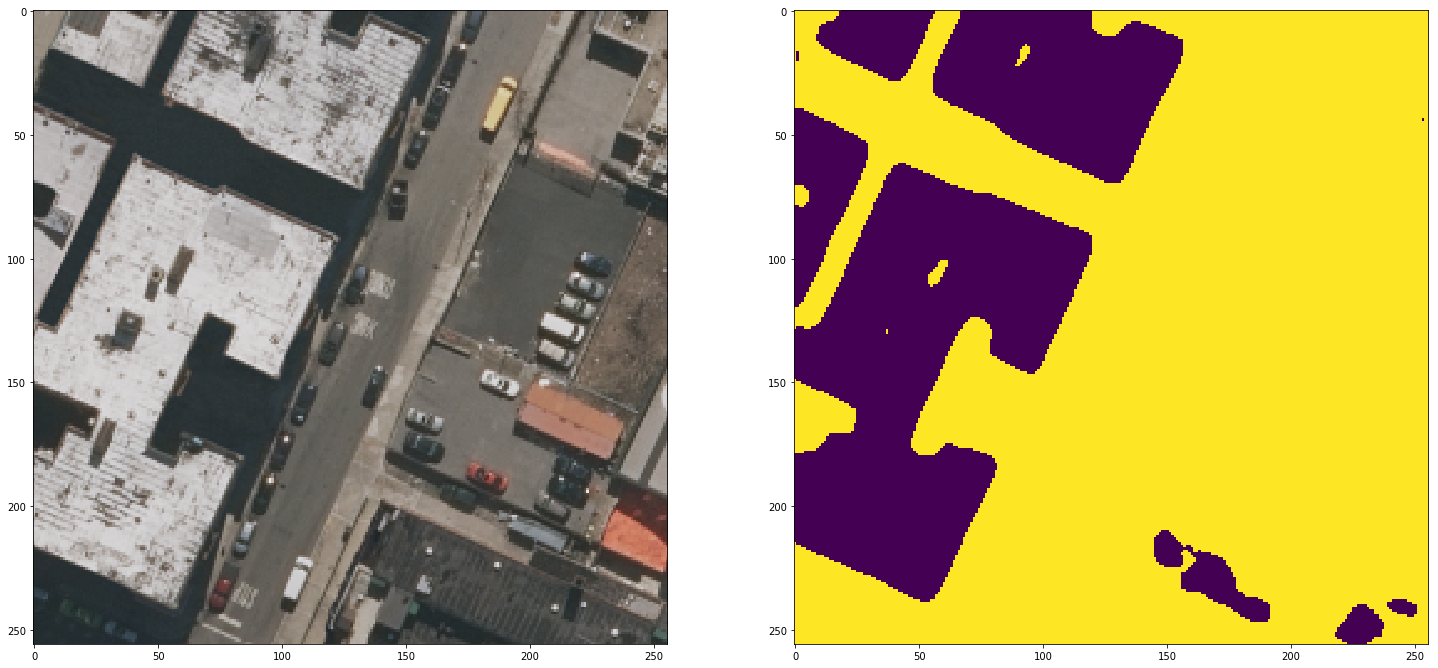

In [70]:
im_id = 15
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
axes[0].imshow(x[im_id])
axes[1].imshow(pred[im_id, ..., 0]>0.5)

plt.show()

In [66]:
pred.shape

(16, 256, 256, 1)